# Feature Engineering

                                                                                        Code Written By : Dasari Mohana
                                                                                        
In this notebook, I will pre-process the variables of the Dataset and do feature engineering therefore we tackle following challenges:

* Duplicate check
* Missing values
* Temporal variables
* Selective transformation of incorrectly scaled values
* Standarise the values of all variables to the same range (Standardization)
* Encoding of Categorical variables
* Forming new meaningful features if needed
* Dropping redundant columns
* Multi-Colinearity check and removal
* Outlier check and removal

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import math as mt
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline
pd.set_option('display.max_columns',None)
warnings.simplefilter(action='ignore')

In [2]:
# Loading the dataset
df = pd.read_csv('zillow_initial_dataset.csv')
df_copy = df.copy()
df.shape

(90275, 60)

In [3]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,transactiondate
0,17073783,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,548.0,1264.0,1264.0,NaN,NaN,548.0,NaN,6111.0,NaN,2.0,2.0,0.0,NaN,NaN,34303597.0,-119287236.0,1735.0,NaN,NaN,NaN,NaN,NaN,1128,265.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97081.0,5.0,NaN,1.0,NaN,NaN,128.0,NaN,1986.0,2.0,NaN,115087.0,191811.0,2015.0,76724.0,2015.06,NaN,NaN,6.111002e+13,0.0953,2016-01-27
1,17088994,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,777.0,777.0,777.0,NaN,NaN,777.0,NaN,6111.0,NaN,1.0,1.0,0.0,NaN,NaN,34272866.0,-119198911.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,NaN,97083.0,4.0,NaN,NaN,NaN,NaN,198.0,NaN,1990.0,1.0,NaN,143809.0,239679.0,2015.0,95870.0,2581.30,NaN,NaN,6.111002e+13,0.0198,2016-03-30
2,17100444,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,1101.0,1101.0,1101.0,NaN,NaN,1101.0,NaN,6111.0,NaN,2.0,2.0,441.0,NaN,NaN,34340801.0,-119079610.0,6569.0,NaN,NaN,NaN,NaN,NaN,1111,261.0,NaN,6.111001e+07,26965.0,2061.0,NaN,97113.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,1956.0,1.0,NaN,33619.0,47853.0,2015.0,14234.0,591.64,NaN,NaN,6.111001e+13,0.0060,2016-05-27
3,17102429,NaN,NaN,NaN,1.5,2.0,NaN,NaN,1.5,NaN,1554.0,1554.0,1554.0,NaN,NaN,1554.0,NaN,6111.0,1.0,1.0,2.0,460.0,NaN,NaN,34354313.0,-119076405.0,7400.0,NaN,NaN,NaN,NaN,NaN,1110,261.0,NaN,6.111001e+07,26965.0,2061.0,NaN,97113.0,5.0,NaN,1.0,NaN,NaN,NaN,NaN,1965.0,1.0,NaN,45609.0,62914.0,2015.0,17305.0,682.78,NaN,NaN,6.111001e+13,-0.0566,2016-06-07
4,17109604,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,1305.0,2415.0,2415.0,NaN,NaN,1305.0,NaN,6111.0,1.0,2.0,2.0,665.0,NaN,NaN,34266578.0,-119165392.0,6326.0,NaN,NaN,NaN,NaN,NaN,1111,261.0,NaN,6.111001e+07,34543.0,2061.0,NaN,97084.0,8.0,NaN,1.0,NaN,NaN,NaN,NaN,1984.0,2.0,NaN,277000.0,554000.0,2015.0,277000.0,5886.92,NaN,NaN,6.111001e+13,0.0573,2016-08-08


## Duplicate Id check and removal

In [4]:
duplicate = df[df.duplicated('parcelid')]
duplicate.shape

(125, 60)

#### Observation:

We can see that there are 125 rows of duplicate data with respect to the same parcelid. Therefore, we will drop them.

In [5]:
df.drop_duplicates(subset ="parcelid", keep = 'first', inplace = True)
df.shape

(90150, 60)

###  Missing Values

In [6]:
df.isnull().mean()*100

parcelid                         0.000000
airconditioningtypeid           68.110926
architecturalstyletypeid        99.711592
basementsqft                    99.952302
bathroomcnt                      0.000000
bedroomcnt                       0.000000
buildingclasstypeid             99.982252
buildingqualitytypeid           36.457016
calculatedbathnbr                1.304493
decktypeid                      99.270105
finishedfloor1squarefeet        92.401553
calculatedfinishedsquarefeet     0.729895
finishedsquarefeet12             5.174709
finishedsquarefeet13            99.963394
finishedsquarefeet15            96.056572
finishedsquarefeet50            92.401553
finishedsquarefeet6             99.535219
fips                             0.000000
fireplacecnt                    89.354409
fullbathcnt                      1.304493
garagecarcnt                    66.836384
garagetotalsqft                 66.836384
hashottuborspa                  97.378813
heatingorsystemtypeid           37

#### Observation:
We can see lot of missing values are there in multiple columns. Therefore, in order to avoid creating synthetic data for columns which have more than 60% missing values, we will drop those columns(>60% null values) and perform feature engineering on the rest of the data.

### Dropping columns having more than 60% Missing values / Null values

In [7]:
def drop_columns_with_max_missing_values(df):
    mis_var = [var for var in df.columns if df[var].isnull().sum() > 0]
    df[mis_var].isnull().sum()

    limit = np.abs((df.shape[0] * 0.6))
    var_to_be_dropped = [var for var in mis_var if df[var].isnull().sum() > limit]
    
    print('Columns with more than 60% missing values: \n', var_to_be_dropped)
    print('\n---- Dropping columns with more than 60% missing values ----\n')

    df.drop(columns=var_to_be_dropped, axis=1, inplace=True)
    
    print('Remaining columns are: \n', df.columns)
    return df

df = drop_columns_with_max_missing_values(df)

Columns with more than 60% missing values: 
 ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear']

---- Dropping columns with more than 60% missing values ----

Remaining columns are: 
 Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycou

In [8]:
df.shape

(90150, 31)

In [9]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate
0,17073783,2.5,3.0,NaN,2.5,1264.0,1264.0,6111.0,2.0,NaN,34303597.0,-119287236.0,1735.0,1128,265.0,NaN,6.111002e+07,34543.0,2061.0,97081.0,5.0,NaN,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,0.0953,2016-01-27
1,17088994,1.0,2.0,NaN,1.0,777.0,777.0,6111.0,1.0,NaN,34272866.0,-119198911.0,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,97083.0,4.0,NaN,1990.0,143809.0,239679.0,2015.0,95870.0,2581.30,6.111002e+13,0.0198,2016-03-30
2,17100444,2.0,3.0,NaN,2.0,1101.0,1101.0,6111.0,2.0,NaN,34340801.0,-119079610.0,6569.0,1111,261.0,NaN,6.111001e+07,26965.0,2061.0,97113.0,5.0,NaN,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,0.0060,2016-05-27
3,17102429,1.5,2.0,NaN,1.5,1554.0,1554.0,6111.0,1.0,NaN,34354313.0,-119076405.0,7400.0,1110,261.0,NaN,6.111001e+07,26965.0,2061.0,97113.0,5.0,NaN,1965.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,-0.0566,2016-06-07
4,17109604,2.5,4.0,NaN,2.5,2415.0,2415.0,6111.0,2.0,NaN,34266578.0,-119165392.0,6326.0,1111,261.0,NaN,6.111001e+07,34543.0,2061.0,97084.0,8.0,NaN,1984.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,0.0573,2016-08-08


### Capture elapsed time

In [10]:
df['yeardifference'] = df['assessmentyear'] - df['yearbuilt']
df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,yeardifference
0,17073783,2.5,3.0,NaN,2.5,1264.0,1264.0,6111.0,2.0,NaN,34303597.0,-119287236.0,1735.0,1128,265.0,NaN,6.111002e+07,34543.0,2061.0,97081.0,5.0,NaN,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,0.0953,2016-01-27,29.0
1,17088994,1.0,2.0,NaN,1.0,777.0,777.0,6111.0,1.0,NaN,34272866.0,-119198911.0,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,97083.0,4.0,NaN,1990.0,143809.0,239679.0,2015.0,95870.0,2581.30,6.111002e+13,0.0198,2016-03-30,25.0
2,17100444,2.0,3.0,NaN,2.0,1101.0,1101.0,6111.0,2.0,NaN,34340801.0,-119079610.0,6569.0,1111,261.0,NaN,6.111001e+07,26965.0,2061.0,97113.0,5.0,NaN,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,0.0060,2016-05-27,59.0
3,17102429,1.5,2.0,NaN,1.5,1554.0,1554.0,6111.0,1.0,NaN,34354313.0,-119076405.0,7400.0,1110,261.0,NaN,6.111001e+07,26965.0,2061.0,97113.0,5.0,NaN,1965.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,-0.0566,2016-06-07,50.0
4,17109604,2.5,4.0,NaN,2.5,2415.0,2415.0,6111.0,2.0,NaN,34266578.0,-119165392.0,6326.0,1111,261.0,NaN,6.111001e+07,34543.0,2061.0,97084.0,8.0,NaN,1984.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,0.0573,2016-08-08,31.0


In [11]:
df.drop(columns=['assessmentyear', 'yearbuilt', 'transactiondate'], axis=1, inplace=True)
df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,yeardifference
0,17073783,2.5,3.0,NaN,2.5,1264.0,1264.0,6111.0,2.0,NaN,34303597.0,-119287236.0,1735.0,1128,265.0,NaN,6.111002e+07,34543.0,2061.0,97081.0,5.0,NaN,115087.0,191811.0,76724.0,2015.06,6.111002e+13,0.0953,29.0
1,17088994,1.0,2.0,NaN,1.0,777.0,777.0,6111.0,1.0,NaN,34272866.0,-119198911.0,NaN,1129,266.0,NaN,6.111002e+07,34543.0,2061.0,97083.0,4.0,NaN,143809.0,239679.0,95870.0,2581.30,6.111002e+13,0.0198,25.0
2,17100444,2.0,3.0,NaN,2.0,1101.0,1101.0,6111.0,2.0,NaN,34340801.0,-119079610.0,6569.0,1111,261.0,NaN,6.111001e+07,26965.0,2061.0,97113.0,5.0,NaN,33619.0,47853.0,14234.0,591.64,6.111001e+13,0.0060,59.0
3,17102429,1.5,2.0,NaN,1.5,1554.0,1554.0,6111.0,1.0,NaN,34354313.0,-119076405.0,7400.0,1110,261.0,NaN,6.111001e+07,26965.0,2061.0,97113.0,5.0,NaN,45609.0,62914.0,17305.0,682.78,6.111001e+13,-0.0566,50.0
4,17109604,2.5,4.0,NaN,2.5,2415.0,2415.0,6111.0,2.0,NaN,34266578.0,-119165392.0,6326.0,1111,261.0,NaN,6.111001e+07,34543.0,2061.0,97084.0,8.0,NaN,277000.0,554000.0,277000.0,5886.92,6.111001e+13,0.0573,31.0


## Transform incorrectly scaled variables

1. As mentioned in the data dictionary, the latitude and longitude has been multiplied to 10^6.

2. I will perform a division of the same to scale it to original.

3. I will perform a similar operation for 'rawcensustractandblock'.

4. Also, I will perform a division of 10^12 for the 'censustractandblock' variable to bring it to original scale.

In [12]:
df[['latitude', 'longitude']] = (df[['latitude', 'longitude']])/(10**6)

df['censustractandblock'] = (df['censustractandblock'])/(10**12)

df['rawcensustractandblock'] = (df['rawcensustractandblock'])/(10**6)

df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,yeardifference
0,17073783,2.5,3.0,NaN,2.5,1264.0,1264.0,6111.0,2.0,NaN,34.303597,-119.287236,1735.0,1128,265.0,NaN,61.110022,34543.0,2061.0,97081.0,5.0,NaN,115087.0,191811.0,76724.0,2015.06,61.110022,0.0953,29.0
1,17088994,1.0,2.0,NaN,1.0,777.0,777.0,6111.0,1.0,NaN,34.272866,-119.198911,NaN,1129,266.0,NaN,61.110015,34543.0,2061.0,97083.0,4.0,NaN,143809.0,239679.0,95870.0,2581.30,61.110015,0.0198,25.0
2,17100444,2.0,3.0,NaN,2.0,1101.0,1101.0,6111.0,2.0,NaN,34.340801,-119.079610,6569.0,1111,261.0,NaN,61.110007,26965.0,2061.0,97113.0,5.0,NaN,33619.0,47853.0,14234.0,591.64,61.110007,0.0060,59.0
3,17102429,1.5,2.0,NaN,1.5,1554.0,1554.0,6111.0,1.0,NaN,34.354313,-119.076405,7400.0,1110,261.0,NaN,61.110008,26965.0,2061.0,97113.0,5.0,NaN,45609.0,62914.0,17305.0,682.78,61.110008,-0.0566,50.0
4,17109604,2.5,4.0,NaN,2.5,2415.0,2415.0,6111.0,2.0,NaN,34.266578,-119.165392,6326.0,1111,261.0,NaN,61.110014,34543.0,2061.0,97084.0,8.0,NaN,277000.0,554000.0,277000.0,5886.92,61.110014,0.0573,31.0


In [13]:
df.shape

(90150, 29)

### Handling missing values:

To deal with missing values in numerical variables, I will replace the missing values in the original variable with the mode

In [14]:
df.isnull().sum()

parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           32866
calculatedbathnbr                1176
calculatedfinishedsquarefeet      658
finishedsquarefeet12             4665
fips                                0
fullbathcnt                      1176
heatingorsystemtypeid           34145
latitude                            0
longitude                           0
lotsizesquarefeet               10136
propertycountylandusecode           1
propertylandusetypeid               0
propertyzoningdesc              31918
rawcensustractandblock              0
regionidcity                     1801
regionidcounty                      0
regionidzip                        35
roomcnt                             0
unitcnt                         31879
structuretaxvaluedollarcnt        378
taxvaluedollarcnt                   1
landtaxvaluedollarcnt               1
taxamount                           6
censustracta

In [15]:
def replace_missing_data(df, mis_vars):
    print('##### Replacing missing values with mode of features #####')
    for var in mis_vars:
        df[var] = df[var].fillna(df[var].mode()[0])
    return df

mis_var = [var for var in df.columns if df[var].isnull().sum() > 0]
df = replace_missing_data(df, mis_var)
df.head()

##### Replacing missing values with mode of features #####


,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,yeardifference
0,17073783,2.5,3.0,7.0,2.5,1264.0,1264.0,6111.0,2.0,2.0,34.303597,-119.287236,1735.0,1128,265.0,LAR1,61.110022,34543.0,2061.0,97081.0,5.0,1.0,115087.0,191811.0,76724.0,2015.06,61.110022,0.0953,29.0
1,17088994,1.0,2.0,7.0,1.0,777.0,777.0,6111.0,1.0,2.0,34.272866,-119.198911,6000.0,1129,266.0,LAR1,61.110015,34543.0,2061.0,97083.0,4.0,1.0,143809.0,239679.0,95870.0,2581.30,61.110015,0.0198,25.0
2,17100444,2.0,3.0,7.0,2.0,1101.0,1101.0,6111.0,2.0,2.0,34.340801,-119.079610,6569.0,1111,261.0,LAR1,61.110007,26965.0,2061.0,97113.0,5.0,1.0,33619.0,47853.0,14234.0,591.64,61.110007,0.0060,59.0
3,17102429,1.5,2.0,7.0,1.5,1554.0,1554.0,6111.0,1.0,2.0,34.354313,-119.076405,7400.0,1110,261.0,LAR1,61.110008,26965.0,2061.0,97113.0,5.0,1.0,45609.0,62914.0,17305.0,682.78,61.110008,-0.0566,50.0
4,17109604,2.5,4.0,7.0,2.5,2415.0,2415.0,6111.0,2.0,2.0,34.266578,-119.165392,6326.0,1111,261.0,LAR1,61.110014,34543.0,2061.0,97084.0,8.0,1.0,277000.0,554000.0,277000.0,5886.92,61.110014,0.0573,31.0


In [17]:
df.isnull().mean()*100

parcelid                        0.0
bathroomcnt                     0.0
bedroomcnt                      0.0
buildingqualitytypeid           0.0
calculatedbathnbr               0.0
calculatedfinishedsquarefeet    0.0
finishedsquarefeet12            0.0
fips                            0.0
fullbathcnt                     0.0
heatingorsystemtypeid           0.0
latitude                        0.0
longitude                       0.0
lotsizesquarefeet               0.0
propertycountylandusecode       0.0
propertylandusetypeid           0.0
propertyzoningdesc              0.0
rawcensustractandblock          0.0
regionidcity                    0.0
regionidcounty                  0.0
regionidzip                     0.0
roomcnt                         0.0
unitcnt                         0.0
structuretaxvaluedollarcnt      0.0
taxvaluedollarcnt               0.0
landtaxvaluedollarcnt           0.0
taxamount                       0.0
censustractandblock             0.0
logerror                    

### Encoding categorical variables (Transforming Categorical Variables to Numerical Variables)

In [19]:
cat_vars = [var for var in df.columns if df[var].dtypes == 'O']
cat_vars

['propertycountylandusecode', 'propertyzoningdesc']

In [20]:
def encode_categorical_variables(df, cat_vars):
    
    print('Categorical variables: ', cat_vars)
    
    for i in range(len(cat_vars)):
        var = cat_vars[i]
        var_le = LabelEncoder()
        var_labels = var_le.fit_transform(df[var])
        var_mappings = {index: label for index, label in enumerate(var_le.classes_)}
        
        df[(var + '_labels')] = var_labels
        df.drop(columns=var, axis=1, inplace=True)
        
    return df

df = encode_categorical_variables(df, cat_vars)
df.head(10)

Categorical variables:  ['propertycountylandusecode', 'propertyzoningdesc']


,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,yeardifference,propertycountylandusecode_labels,propertyzoningdesc_labels
0,17073783,2.5,3.0,7.0,2.5,1264.0,1264.0,6111.0,2.0,2.0,34.303597,-119.287236,1735.0,265.0,61.110022,34543.0,2061.0,97081.0,5.0,1.0,115087.0,191811.0,76724.0,2015.06,61.110022,0.0953,29.0,54,609
1,17088994,1.0,2.0,7.0,1.0,777.0,777.0,6111.0,1.0,2.0,34.272866,-119.198911,6000.0,266.0,61.110015,34543.0,2061.0,97083.0,4.0,1.0,143809.0,239679.0,95870.0,2581.30,61.110015,0.0198,25.0,55,609
2,17100444,2.0,3.0,7.0,2.0,1101.0,1101.0,6111.0,2.0,2.0,34.340801,-119.079610,6569.0,261.0,61.110007,26965.0,2061.0,97113.0,5.0,1.0,33619.0,47853.0,14234.0,591.64,61.110007,0.0060,59.0,50,609
3,17102429,1.5,2.0,7.0,1.5,1554.0,1554.0,6111.0,1.0,2.0,34.354313,-119.076405,7400.0,261.0,61.110008,26965.0,2061.0,97113.0,5.0,1.0,45609.0,62914.0,17305.0,682.78,61.110008,-0.0566,50.0,49,609
4,17109604,2.5,4.0,7.0,2.5,2415.0,2415.0,6111.0,2.0,2.0,34.266578,-119.165392,6326.0,261.0,61.110014,34543.0,2061.0,97084.0,8.0,1.0,277000.0,554000.0,277000.0,5886.92,61.110014,0.0573,31.0,50,609
5,17125829,2.5,4.0,7.0,2.5,2882.0,2882.0,6111.0,2.0,2.0,34.240014,-119.024793,10000.0,261.0,61.110052,51239.0,2061.0,97089.0,8.0,1.0,222070.0,289609.0,67539.0,3110.44,61.110052,0.0564,35.0,50,609
6,17132911,2.0,3.0,7.0,2.0,1772.0,1772.0,6111.0,2.0,2.0,34.226842,-119.059815,8059.0,261.0,61.110055,51239.0,2061.0,97089.0,6.0,1.0,185000.0,526000.0,341000.0,5632.20,61.110055,0.0315,37.0,50,609
7,17134926,2.5,5.0,7.0,2.5,2632.0,2632.0,6111.0,2.0,2.0,34.229816,-119.050224,7602.0,261.0,61.110055,51239.0,2061.0,97089.0,8.0,1.0,342611.0,571086.0,228475.0,6109.94,61.110055,0.0257,44.0,50,609
8,17139988,2.0,3.0,7.0,2.0,1292.0,1292.0,6111.0,2.0,2.0,34.226351,-118.983853,7405.0,261.0,61.110053,51239.0,2061.0,97091.0,6.0,1.0,231297.0,462594.0,231297.0,5026.40,61.110053,0.0020,36.0,50,609
9,17167359,1.0,3.0,7.0,1.0,1385.0,1385.0,6111.0,1.0,2.0,34.179289,-119.169287,6000.0,261.0,61.110039,13150.0,2061.0,97104.0,6.0,1.0,134251.0,268502.0,134251.0,3217.06,61.110039,-0.0576,65.0,50,609


### Checking Outliers & Removing them

In [22]:
df.shape

(90150, 29)

In [21]:
# Using Z-score as a threhold (WE can also find outliers using IQR and boxplot)

z = np.abs(stats.zscore(df))
no_out_df = df[(z<3).all(axis=1)]
no_out_df.shape

(70260, 29)

### Checking for Multi-Colinearity

In [23]:
correlation = no_out_df.corr()

<AxesSubplot:>

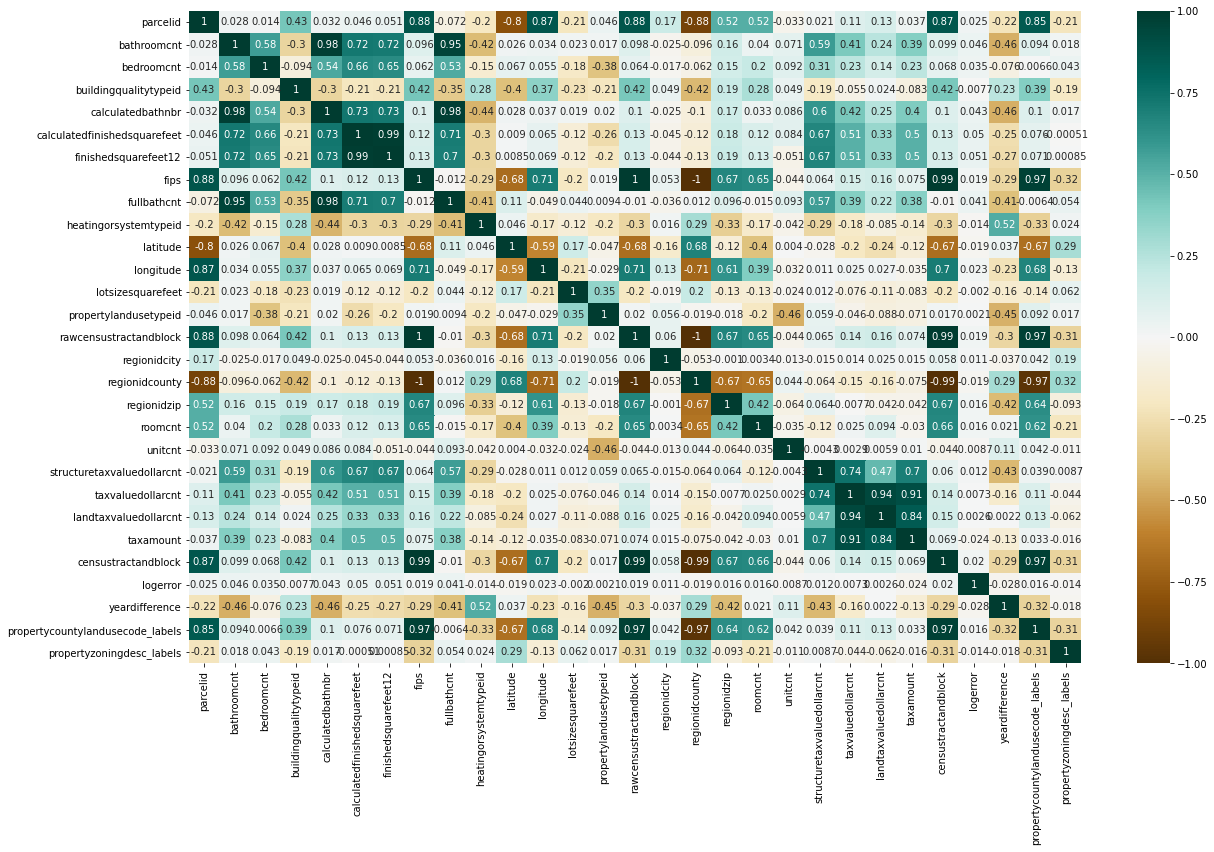

In [27]:
plt.figure(figsize=(20,12))
sns.heatmap(correlation, cmap='BrBG', annot=True)

#### Observation:
We observe high correlation among some of the feature variables from the above correlation plot. Therefore we will drop some of the features and then build our model on top of that.

<AxesSubplot:>

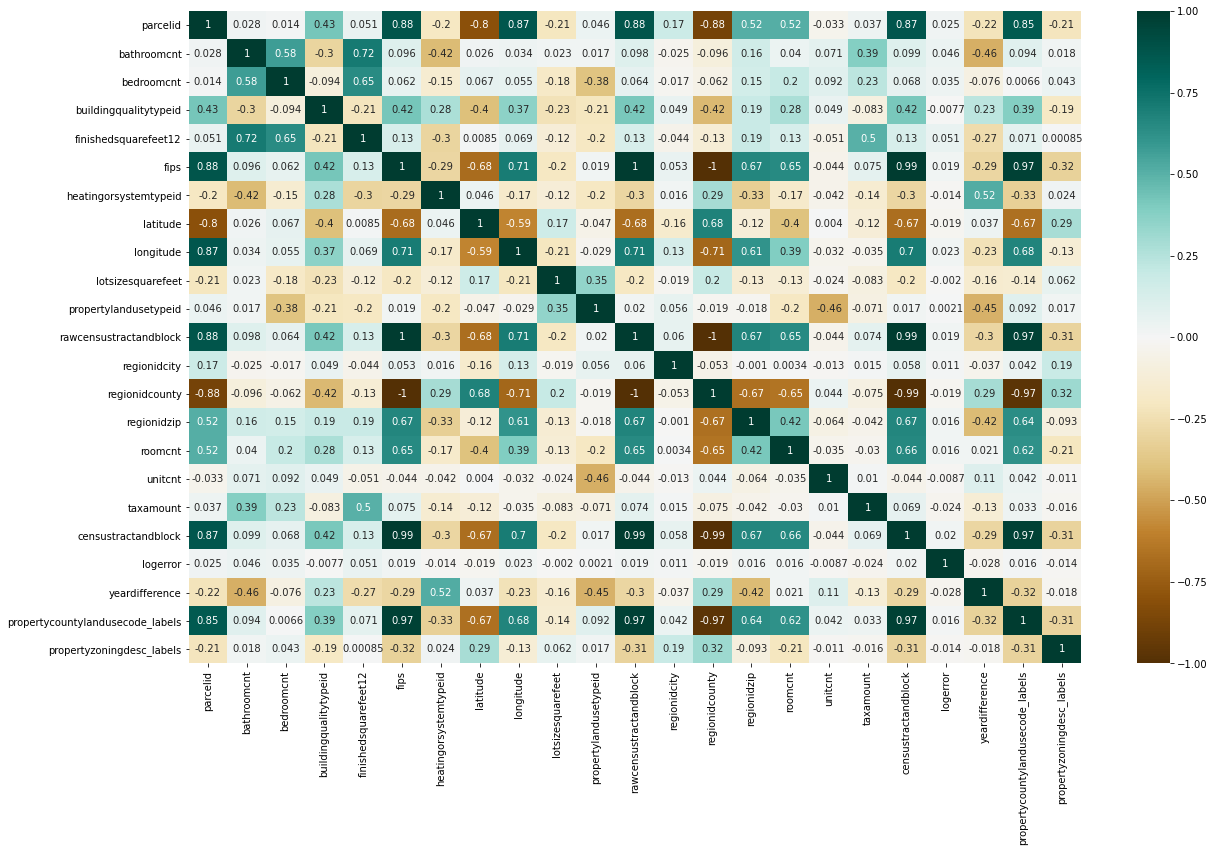

In [28]:
no_out_df.drop(columns=['calculatedbathnbr', 'calculatedfinishedsquarefeet', 'structuretaxvaluedollarcnt', 
                        'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'fullbathcnt'], axis=1, inplace=True)

plt.figure(figsize=(20,12))
sns.heatmap(no_out_df.corr(), cmap='BrBG',annot=True)

### Re-Examining Dataset

In [29]:
no_out_df.shape

(70260, 23)

In [30]:
no_out_df.head()

,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,finishedsquarefeet12,fips,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,unitcnt,taxamount,censustractandblock,logerror,yeardifference,propertycountylandusecode_labels,propertyzoningdesc_labels
26,10726315,3.0,3.0,4.0,2445.0,6037.0,2.0,34.184300,-118.657000,63878.0,266.0,60.371352,12447.0,3101.0,96389.0,0.0,1.0,7170.22,60.371352,0.0383,33.0,9,627
27,10727091,2.0,3.0,7.0,1160.0,6037.0,2.0,34.188121,-118.646361,7688.0,261.0,60.371352,12447.0,3101.0,96342.0,0.0,1.0,5421.96,60.371352,0.0030,55.0,2,638
28,10730788,2.0,4.0,7.0,1570.0,6037.0,2.0,34.188446,-118.616724,11308.0,261.0,60.371351,12447.0,3101.0,96342.0,0.0,1.0,5097.78,60.371351,-0.0020,56.0,2,638
29,10735394,3.0,4.0,4.0,2863.0,6037.0,2.0,34.171439,-118.646883,16376.0,261.0,60.371373,12447.0,3101.0,96389.0,0.0,1.0,7475.21,60.371373,0.0129,52.0,3,632
31,10743512,3.0,2.0,4.0,1394.0,6037.0,2.0,34.152890,-118.791494,77543.0,269.0,60.378003,34278.0,3101.0,96385.0,0.0,1.0,5550.36,60.378003,0.0630,17.0,10,769


#### Observation:
1. Due to repetitive data, we will drop 1 of rawcensustractandblock and censustractandblock.
2. The propertycountylandusecode_labels will serve no useful purpose for our model prediction.
3. parcelid will also serve no use for our prediction.
4. Therefore, we will drop those columns and build a model on top of this data

In [31]:
no_out_df.drop(columns=['censustractandblock', 'propertycountylandusecode_labels'], axis=1, inplace=True)
no_out_df.shape

(70260, 21)

In [32]:
# Saving final Dataset

no_out_df.to_csv('final_zillow_dataset.csv', index=False)

## Conclusion:
We have performed all the feature engineering steps necessary to ensure the dataset is ready to be fed into Machine Learning algorithms. Finally, We split the dataset into train and test set and build ML model for predictions